In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset
import librosa
import librosa.display
import glob
from torchvision.datasets import DatasetFolder
from torchvision import models, transforms
from PIL import Image
import PIL
from matplotlib import cm
import cv2
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time

In [2]:
class ComSet(DatasetFolder):
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        y, sr = librosa.load(path)
        sample = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
#         sample = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        sample = librosa.power_to_db(sample, ref=np.max)
#         sample = cv2.merge((sample,sample,sample))
        
        pil_sample = Image.fromarray(sample)
#         pil_sample = cv2.merge((pil_sample,pil_sample,pil_sample))
        if self.transform is not None:
            sample = self.transform(pil_sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

In [3]:
image_transforms = { 
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224),
#         transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ])
}

In [4]:
train_data = ComSet('dataSound/train', loader=librosa.load, extensions=('ogg', 'oga'), transform=image_transforms['train'])
test_data = ComSet('dataSound/test', loader=librosa.load, extensions=('ogg', 'oga'), transform=image_transforms['test'])

In [5]:
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
print(idx_to_class)

{0: 'ask', 1: 'dance', 2: 'other', 3: 'turn_left', 4: 'turn_right'}


In [6]:
len(train_data)

167

In [7]:
len(test_data)

40

<class 'torch.Tensor'>
<class 'torch.Tensor'>


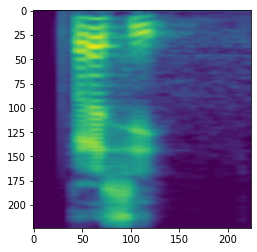

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [8]:
s, t = train_data[0]
print(type(s))
plt.imshow(s.permute(1,2,0))
# print(t)
# s = Image.fromarray(s)
# plt.imshow(pil_sample)
print(type(s))
# sample.shape

<class 'torch.Tensor'>
0


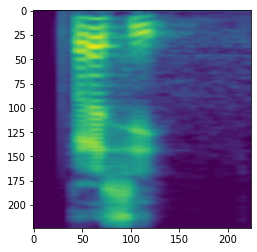

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [9]:
s, t = train_data[0]
print(type(s))
plt.imshow(s.permute(1, 2, 0))
print(t)

In [8]:
y_train = [pair[1] for pair in train_data]
print(len(y_train))
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
class_weights = 1. / class_sample_count
samples_weight = np.array([class_weights[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
train_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
class_sample_count

167


array([35, 37, 71, 12, 12])

In [9]:
y_test = [pair[1] for pair in test_data]
print(len(y_test))
class_sample_count = np.array(
    [len(np.where(y_test == t)[0]) for t in np.unique(y_test)])
class_weights = 1. / class_sample_count
samples_weight = np.array([class_weights[t] for t in y_test])
samples_weight = torch.from_numpy(samples_weight)
test_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
class_sample_count

40


array([8, 8, 8, 8, 8])

In [10]:
# class_weights = 1. / class_sample_count
# samples_weight = np.array([class_weights[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)
# print(len(samples_weight))
# # sampler = WeightedRandomSampler([0.2, 0.2, 0.2, 0.2, 0.2], 5, replacement=True)
# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_data_loader = DataLoader(train_data, batch_size=5, drop_last=True, sampler=train_sampler)
test_data_loader = DataLoader(test_data, batch_size=40, drop_last=False)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


In [12]:
resnet18 = models.resnet18(pretrained=True)
weight = resnet18.conv1.weight.clone()
resnet18
# resnet50 = resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
with torch.no_grad():
    resnet18.conv1.weight[:, 0] = weight[:, 0]

In [14]:
# for param in resnet18.parameters():
#     param.requires_grad = False

In [15]:
fc_inputs = resnet18.fc.in_features

resnet18.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 5),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet18 = resnet18.to(device)

In [16]:
print(resnet18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet18.parameters())

In [18]:
def train_and_test(model, loss_criterion, optimizer, epochs=25):

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

#             print(inputs.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
#         if valid_loss < best_loss:
#             best_loss = valid_loss
#             best_epoch = epoch
#             best_model = model

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_data) 
        avg_train_acc = train_acc/len(train_data)

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/len(test_data)
        avg_valid_acc = valid_acc/len(test_data)
        
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_epoch = epoch
            best_model = model    

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
            
    return model, history, best_epoch, best_model, best_loss

In [20]:
# print(resnet18)
num_epochs = 300
trained_model, history, best_epoch, best_model, best_loss = train_and_test(resnet18, loss_func, optimizer, num_epochs)
torch.save(best_model, 'resnet18_mel_spec.pt')
print(best_epoch, best_loss)

# torch.save(history, dataset+'_history.pt')

Epoch: 1/300
Epoch : 000, Training: Loss - 0.0180, Accuracy - 98.2036%, 
		Validation : Loss - 0.3755, Accuracy - 87.5000%, Time: 3.7114s
Epoch: 2/300
Epoch : 001, Training: Loss - 0.0115, Accuracy - 98.2036%, 
		Validation : Loss - 0.4199, Accuracy - 90.0000%, Time: 3.8014s
Epoch: 3/300
Epoch : 002, Training: Loss - 0.0119, Accuracy - 98.2036%, 
		Validation : Loss - 0.3236, Accuracy - 92.5000%, Time: 3.9110s
Epoch: 4/300
Epoch : 003, Training: Loss - 0.0570, Accuracy - 95.8084%, 
		Validation : Loss - 1.7712, Accuracy - 87.5000%, Time: 3.8537s
Epoch: 5/300
Epoch : 004, Training: Loss - 0.1003, Accuracy - 95.8084%, 
		Validation : Loss - 0.3405, Accuracy - 87.5000%, Time: 3.7015s
Epoch: 6/300
Epoch : 005, Training: Loss - 0.0339, Accuracy - 97.6048%, 
		Validation : Loss - 0.5052, Accuracy - 90.0000%, Time: 3.7350s
Epoch: 7/300
Epoch : 006, Training: Loss - 0.0176, Accuracy - 98.2036%, 
		Validation : Loss - 0.3445, Accuracy - 92.5000%, Time: 3.9169s
Epoch: 8/300
Epoch : 007, Training

In [20]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    predict = model(xb)
    loss = loss_func(predict, yb)
    predict = [torch.argmax(pred) for pred  in predict]
    predict = torch.stack(predict, 0)
    trueCount = 0
    for i in range(len(yb)):
        if predict[i] == yb[i]:
            trueCount += 1
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb), trueCount / len(yb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        _, numsT, acc_train = zip(*[loss_batch(model, loss_func, xb.cuda(), yb.cuda(), opt) for xb, yb in train_dl])

        model.eval()
        with torch.no_grad():
            losses, nums, acc_val = zip(
                *[loss_batch(model, loss_func, xb.cuda(), yb.cuda()) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
#         accuracy_train = np.mean(acc_train)
#         accuracy_val = np.mean(acc_val)
        accuracy_val = np.sum(np.multiply(acc_val, nums)) / np.sum(nums)
        accuracy_train = np.sum(np.multiply(acc_train, numsT)) / np.sum(numsT)

#         writer.add_scalar("Acc_Val", accuracy_val, epoch)
        print(epoch, val_loss, accuracy_train, accuracy_val)

In [21]:
epochs = 40
fit(epochs, resnet18, loss_func, optimizer, train_data_loader, test_data_loader)

0 1.5630728006362915 0.41711229946524064 0.3
1 1.609072780609131 0.40641711229946526 0.4
2 1.5285900592803956 0.39037433155080214 0.35
3 1.4919344067573548 0.45454545454545453 0.25
4 1.2378729104995727 0.39572192513368987 0.5
5 1.3454568147659303 0.47058823529411764 0.35
6 1.3819142818450927 0.48663101604278075 0.3
7 1.1972660660743712 0.48663101604278075 0.55
8 1.4929341077804565 0.5187165775401069 0.25
9 1.22828106880188 0.5508021390374331 0.6
10 1.1559080123901366 0.5347593582887701 0.5
11 1.2444284200668334 0.5080213903743316 0.4
12 1.0268980622291566 0.5508021390374331 0.6
13 1.2198159098625183 0.48128342245989303 0.3
14 1.1471232652664185 0.5454545454545454 0.6


KeyboardInterrupt: 